<a href="https://colab.research.google.com/github/Riskaseptianaa/Images-Retrieval-140-175/blob/main/ProjectCBIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Dataset

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import scipy
from IPython import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from skimage.feature import hog
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import KFold
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
import xgboost as xgb
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/TKC-new"

In [14]:
%cd /content/gdrive/My Drive/TKC-new

/content/gdrive/My Drive/TKC-new


In [ ]:
!ls

flowers  flowers.zip


In [29]:
DATADIR="/content/gdrive/MyDrive/TKC-new/flowers"
CATEGORIES=["flowers"]
training_data=[]
i = 1
for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num=CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array=cv2.imread(os.path.join(path,img))
            new_image=np.asarray(cv2.resize(img_array,(300,300)))
            training_data.append([new_image, class_num])
            print("Gambar termuat : ",i)
            display.clear_output(wait=True)
            i=i+1
        except Exception as e:
            pass## Load Image Data

Gambar termuat :  100


## Splitting

In [30]:
X = []
y = []
for image,label in training_data:
    X.append(image)
    y.append(label)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify=y)

In [32]:
print("Jumlah data latih : ",np.shape(X_train)[0])
print("Jumlah data uji   : ",np.shape(X_test)[0]) 

Jumlah data latih :  80
Jumlah data uji   :  20


## Preprocessing

In [33]:
def preprocessing1(arr):
    arr_prep=[]
    for i in range(np.shape(arr)[0]):
        img=cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        arr_prep.append(img)
    return arr_prep

def preprocessing2(arr):
    arr_prep=[]
    for i in range(np.shape(arr)[0]):
        image=cv2.cvtColor(arr[i], cv2.COLOR_BGR2GRAY)
        arr_prep.append(image)
    return arr_prep

def preprocessing3(arr):
    arr_prep=[]
    for i in range(np.shape(arr)[0]):
        image=cv2.cvtColor(arr[i], cv2.COLOR_BGR2HSV)
        arr_prep.append(image)
    return arr_prep

## Feature Extraction

In [34]:
def FtrExtractHOG(img):
    ftr,_=hog(img, orientations=9, pixels_per_cell=(50, 50),
            cells_per_block=(2, 2), visualize=True, multichannel=False, block_norm= 'L2')
    return ftr

def FtrExtractGLCM(img, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
        
    return feature

def FtrExtractHSV(img):
    chans = cv2.split(img)
    features = []

    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)
    return np.array(features).flatten()

In [35]:
def featureExtraction1(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(FtrExtractHOG(arr[i]))
    return arr_feature

properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
def featureExtraction2(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(FtrExtractGLCM(arr[i],props=properties))
    return arr_feature

def featureExtraction3(arr):
    arr_feature=[]
    for i in range(np.shape(arr)[0]):
        arr_feature.append(FtrExtractHSV(arr[i]))
    return arr_feature

## K-Fold Cross Validation

In [36]:
def kfold_1(X_train,y_train,K,stat):

  cvscores = []
  i = 1
  skf = KFold(n_splits=K)

  X_train_ = np.array(X_train)
  y_train = np.array(y_train)
  if (stat==1):
      RF = RandomForestClassifier(n_estimators=400, random_state = 42)
      for train_index,val_index in skf.split(X_train_):
        x_train_new,x_val=X_train_[train_index],X_train_[val_index]
        y_train_new,y_val=y_train[train_index],y_train[val_index]

        RF.fit(x_train_new, y_train_new)

        y_pred = RF.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        print("Fold ke",i," -> ",end=" ")
        print("%.3f%%"%(acc*100))
        i=i+1
        cvscores.append(acc)
  elif (stat==2):
      DTL = DecisionTreeClassifier(criterion="entropy", min_samples_split=20, random_state=42)
      for train_index,val_index in skf.split(X_train_):
        x_train_new,x_val=X_train_[train_index],X_train_[val_index]
        y_train_new,y_val=y_train[train_index],y_train[val_index]

        DTL.fit(x_train_new, y_train_new)

        y_pred = DTL.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        print("Fold ke",i," -> ",end=" ")
        print("%.3f%%"%(acc*100))
        i=i+1
        cvscores.append(acc)

  elif (stat==3):
      XG = xgb.XGBClassifier(subsample=0.8, learning_rate=0.1)
      for train_index,val_index in skf.split(X_train_):
        x_train_new,x_val=X_train_[train_index],X_train_[val_index]
        y_train_new,y_val=y_train[train_index],y_train[val_index]

        XG.fit(x_train_new, y_train_new)

        y_pred = XG.predict(x_val)
        acc = accuracy_score(y_val, y_pred)
        print("Fold ke",i," -> ",end=" ")
        print("%.3f%%"%(acc*100))
        i=i+1
        cvscores.append(acc)
  
  return cvscores

In [37]:
X_trainp_shape=preprocessing1(X_train)
X_testp_shape=preprocessing1(X_test)

X_trainp_texture=preprocessing2(X_train)
X_testp_texture=preprocessing2(X_test)

X_trainp_color=preprocessing3(X_train)
X_testp_color=preprocessing3(X_test)

In [38]:
X_trainftr_shape=featureExtraction1(X_trainp_shape)
X_testftr_shape=featureExtraction1(X_testp_shape)

X_trainftr_texture=featureExtraction2(X_trainp_texture)
X_testftr_texture=featureExtraction2(X_testp_texture)

X_trainftr_color=featureExtraction3(X_trainp_color)
X_testftr_color=featureExtraction3(X_testp_color)

In [39]:
X_trainftr_combined = np.concatenate((X_trainftr_shape,X_trainftr_texture,X_trainftr_color),axis=1)
X_testftr_combined = np.concatenate((X_testftr_shape,X_testftr_texture,X_testftr_color),axis=1)

In [40]:
print("Dimensi fitur bentuk  : ",np.shape(X_trainftr_shape)[1])
print("Dimensi fitur tekstur : ",np.shape(X_trainftr_texture)[1])
print("Dimensi fitur warna   : ",np.shape(X_trainftr_color)[1])
print("Dimensi fitur gabungan: ",np.shape(X_trainftr_combined)[1])

Dimensi fitur bentuk  :  900
Dimensi fitur tekstur :  24
Dimensi fitur warna   :  768
Dimensi fitur gabungan:  1692


## CNN

In [41]:
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

mean_image = np.mean(X_train, axis = 0)

X_train -= mean_image
X_test -= mean_image

In [42]:
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [43]:
def create_inception_model():
  model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3), pooling='max')
  x = model.output
  predictions = Dense(1, activation='softmax')(x)
  myModel_scratch = Model(inputs=model.input, outputs=predictions, name='InceptionV3')

  opt = keras.optimizers.Adam(learning_rate=0.0001)
  myModel_scratch.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return myModel_scratch

In [44]:
def kfold_2(X_train,y_train,K):

  model_validation=create_inception_model()
  cvscores = []
  i = 1
  skf = KFold(n_splits=K)

  X_train_ = np.array(X_train)
  y_train = np.array(y_train)
  for train_index,val_index in skf.split(X_train_):
    x_train_new,x_val=X_train_[train_index],X_train_[val_index]
    y_train_new,y_val=y_train[train_index],y_train[val_index]

    model_validation.fit(x_train_new, y_train_new, validation_data = (x_val,y_val), epochs=20, verbose=0)

    scores = model_validation.evaluate(x_val, y_val, verbose=0)
    # print("Fold ke",i," -> ",scores[1]*100,"%")
    print("Fold ke",i," -> ",end=" ")
    print("%.3f%%"%(scores[1]*100))
    i=i+1
    cvscores.append(scores[1])

  return cvscores

In [45]:
inception_validation = kfold_2(X_train,y_train_binary,50)
print("Akurasi Validasi CNN-Inception : %.3f%%" % (np.average(inception_validation)*100))

Fold ke 1  ->  100.000%
Fold ke 2  ->  100.000%
Fold ke 3  ->  100.000%
Fold ke 4  ->  100.000%
Fold ke 5  ->  100.000%
Fold ke 6  ->  100.000%
Fold ke 7  ->  100.000%
Fold ke 8  ->  100.000%
Fold ke 9  ->  100.000%
Fold ke 10  ->  100.000%
Fold ke 11  ->  100.000%
Fold ke 12  ->  100.000%
Fold ke 13  ->  100.000%
Fold ke 14  ->  100.000%
Fold ke 15  ->  100.000%
Fold ke 16  ->  100.000%
Fold ke 17  ->  100.000%
Fold ke 18  ->  100.000%
Fold ke 19  ->  100.000%
Fold ke 20  ->  100.000%
Fold ke 21  ->  100.000%
Fold ke 22  ->  100.000%
Fold ke 23  ->  100.000%
Fold ke 24  ->  100.000%
Fold ke 25  ->  100.000%
Fold ke 26  ->  100.000%
Fold ke 27  ->  100.000%
Fold ke 28  ->  100.000%
Fold ke 29  ->  100.000%
Fold ke 30  ->  100.000%
Fold ke 31  ->  100.000%
Fold ke 32  ->  100.000%
Fold ke 33  ->  100.000%
Fold ke 34  ->  100.000%
Fold ke 35  ->  100.000%
Fold ke 36  ->  100.000%
Fold ke 37  ->  100.000%
Fold ke 38  ->  100.000%
Fold ke 39  ->  100.000%
Fold ke 40  ->  100.000%
Fold ke 4

In [46]:
RF = RandomForestClassifier(n_estimators=400, random_state = 42)
RF.fit(X_trainftr_combined, y_train)
y_pred_RF = RF.predict(X_testftr_combined)
print("Akurasi Testing RF : %.3f%%"% (accuracy_score(y_test, y_pred_RF)*100))

Akurasi Testing RF : 100.000%


In [47]:
model = create_inception_model()
model.fit(X_train, y_train_binary,epochs=50)

Epoch 1/50
3/3 [==============================] - 16s 3s/step - loss: 0.0773 - accuracy: 1.0000
Epoch 2/50
3/3 [==============================] - 3s 813ms/step - loss: 1.9189e-04 - accuracy: 1.0000
Epoch 3/50
3/3 [==============================] - 3s 812ms/step - loss: 2.6348e-05 - accuracy: 1.0000
Epoch 4/50
3/3 [==============================] - 3s 810ms/step - loss: 1.8593e-05 - accuracy: 1.0000
Epoch 5/50
3/3 [==============================] - 3s 807ms/step - loss: 1.1851e-05 - accuracy: 1.0000
Epoch 6/50
3/3 [==============================] - 3s 807ms/step - loss: 1.0523e-05 - accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 3s 810ms/step - loss: 7.2246e-06 - accuracy: 1.0000
Epoch 8/50
3/3 [==============================] - 3s 806ms/step - loss: 6.7721e-06 - accuracy: 1.0000
Epoch 9/50
3/3 [==============================] - 3s 805ms/step - loss: 4.7227e-06 - accuracy: 1.0000
Epoch 10/50
3/3 [==============================] - 3s 806ms/step - loss: 5.3892e-06 - ac

In [48]:
predictions = model.predict(X_test , batch_size = 32).argmax(axis = 1)
print(classification_report(y_test_binary.argmax(axis = 1), predictions))
print(confusion_matrix(y_test_binary.argmax(axis = 1), predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

[[20]]


In [49]:
accuracy = model.evaluate(X_test, y_test_binary, verbose=1)
print('Test loss    :', accuracy[0])
print('Test accuracy: %.2f%%' % (accuracy[1]*100))

1/1 [==============================] - 2s 2s/step - loss: 0.1424 - accuracy: 1.0000
Test loss    : 0.1423698514699936
Test accuracy: 100.00%


In [51]:
model.save('model.h5')

## Model 2

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             horizontal_flip=True,
                             width_shift_range =1,
                             height_shift_range = 1,
                             shear_range = 0.2,
                             fill_mode = 'nearest')

In [16]:
target_size = (300,300)
batch_size = 32

train = '/content/gdrive/MyDrive/TKC-new/model-flowers/training'
train_generator = datagen.flow_from_directory(train,
                                                batch_size = batch_size,
                                                target_size = target_size,
                                                color_mode = 'rgb',
                                                shuffle = False,
                                                class_mode = 'categorical')

validation = '/content/gdrive/MyDrive/TKC-new/model-flowers/test'
test_generator = datagen.flow_from_directory(validation,
                                                batch_size = batch_size,
                                                target_size = target_size,
                                                color_mode = 'rgb',
                                                shuffle = False,
                                                class_mode = 'categorical')

Found 75 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


In [53]:
# Model Scenario Kedua
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPooling2D, AveragePooling2D, GlobalMaxPooling2D

model2 = Sequential()

model2.add(InputLayer(input_shape=[300,300,3]))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(GlobalMaxPooling2D())
model2.add(Flatten())

# Fully Connected Layer
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='softmax'))

print(model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 300, 300, 16)      448       
                                                                 
 average_pooling2d_18 (Avera  (None, 150, 150, 16)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_189 (Conv2D)         (None, 150, 150, 32)      4640      
                                                                 
 average_pooling2d_19 (Avera  (None, 75, 75, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_190 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 average_pooling2d_20 (Avera  (None, 38, 38, 64)       0

In [54]:
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [55]:
H2 = model2.fit(train_generator, epochs= 50, validation_data = test_generator)

Epoch 1/50
3/3 [==============================] - 5s 2s/step - loss: 0.5040 - acc: 1.0000 - val_loss: 0.2759 - val_acc: 1.0000
Epoch 2/50
3/3 [==============================] - 2s 813ms/step - loss: 0.2017 - acc: 1.0000 - val_loss: 0.0249 - val_acc: 1.0000
Epoch 3/50
3/3 [==============================] - 2s 831ms/step - loss: 0.0133 - acc: 1.0000 - val_loss: 2.5391e-04 - val_acc: 1.0000
Epoch 4/50
3/3 [==============================] - 2s 807ms/step - loss: 1.6891e-04 - acc: 1.0000 - val_loss: 9.0614e-07 - val_acc: 1.0000
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 1.0238e-07 - acc: 1.0000 - val_loss: 3.0791e-09 - val_acc: 1.0000
Epoch 6/50
3/3 [==============================] - 2s 817ms/step - loss: 1.7695e-09 - acc: 1.0000 - val_loss: 1.3959e-11 - val_acc: 1.0000
Epoch 7/50
3/3 [==============================] - 2s 1s/step - loss: 1.6485e-12 - acc: 1.0000 - val_loss: 1.2209e-13 - val_acc: 1.0000
Epoch 8/50
3/3 [==============================] - 2s 831ms/step

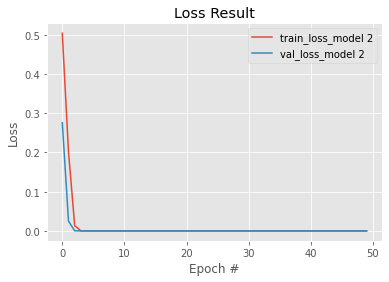

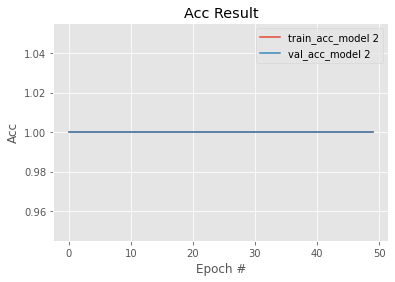

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H2.history["loss"], label="train_loss_model 2")
plt.plot(np.arange(0, 50), H2.history["val_loss"], label="val_loss_model 2")
plt.title("Loss Result")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H2.history["acc"], label="train_acc_model 2")
plt.plot(np.arange(0, 50), H2.history["val_acc"], label="val_acc_model 2")
plt.title("Acc Result")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy: 100.00%


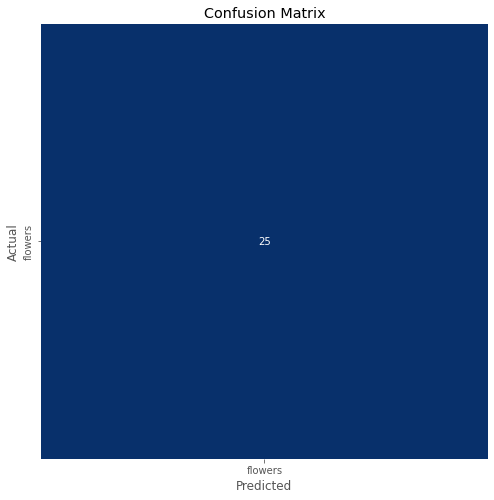

Classification Report:
----------------------
               precision    recall  f1-score   support

     flowers       1.00      1.00      1.00        25

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



In [57]:
import seaborn as sns
target_name = ['flowers']
acc = model2.evaluate(test_generator, verbose=0)
print("Accuracy: {:.2f}%".format(acc[1] * 100))

predictions = np.argmax(model2.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions, labels=[0])
clr = classification_report(test_generator.labels, predictions, labels=[0], target_names=target_name)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5], labels=target_name)
plt.yticks(ticks=[0.5,], labels=target_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [58]:
model2.save('model2.h5')

## Model 3

In [60]:
# Tulis Program Anda Disini!
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, AveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB0
from google.colab import files

In [61]:
baseModel = VGG16(include_top=False, input_tensor=Input(shape=(300,300,3)))

In [62]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Dropout(0.5)(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='relu')(headModel)
    headModel = Dense(classes, activation='softmax')(headModel)
    return headModel

In [63]:
from tensorflow.keras.models import Model

headModel = FCHeadNet.build(baseModel, 3, 128)
model3 = Model(inputs=baseModel.input, outputs=headModel)

In [64]:
for layer in baseModel.layers:
  layer.trainable = False

In [65]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [66]:
model3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

reduce_callback = ReduceLROnPlateau(monitor='val_loss',mode="max", patience=10, factor=0.5, min_lr=0.001, verbose=1)
callbacks_list = [ reduce_callback]

In [68]:
H3 = model3.fit(train_generator,
              epochs = 50,
              validation_data = test_generator,
              #callbacks = [callbacks_list]
              )

Epoch 1/50
3/3 [==============================] - 5s 2s/step - loss: 11.3394 - acc: 0.1467 - val_loss: 16.0109 - val_acc: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 8.1396 - acc: 0.4000 - val_loss: 7.1855 - val_acc: 1.0000
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 5.7131 - acc: 0.5733 - val_loss: 6.9612 - val_acc: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 5.7398 - acc: 0.0800 - val_loss: 5.1742 - val_acc: 1.0000
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 5.6384 - acc: 0.8933 - val_loss: 5.2710 - val_acc: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 5.7758 - acc: 0.0400 - val_loss: 3.8589 - val_acc: 0.9600
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 4.5885 - acc: 0.7333 - val_loss: 4.2741 - val_acc: 0.0000e+00
Epoch 8/50
3/3 [==============================] - 3s 1s/step - loss: 5.5624 - acc: 0.0533 - v

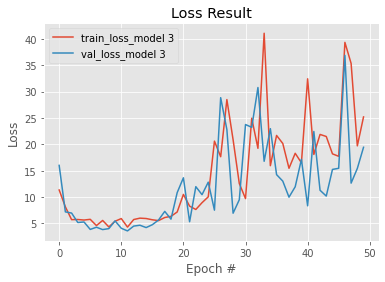

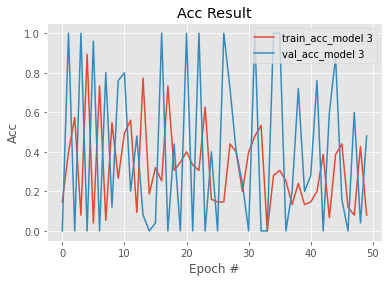

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H3.history["loss"], label="train_loss_model 3")
plt.plot(np.arange(0, 50), H3.history["val_loss"], label="val_loss_model 3")
plt.title("Loss Result")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H3.history["acc"], label="train_acc_model 3")
plt.plot(np.arange(0, 50), H3.history["val_acc"], label="val_acc_model 3")
plt.title("Acc Result")
plt.xlabel("Epoch #")
plt.ylabel("Acc")
plt.legend()
plt.show()

Accuracy: 52.00%


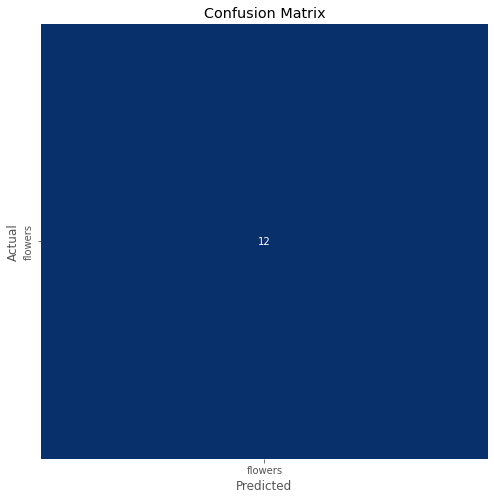

Classification Report:
----------------------
               precision    recall  f1-score   support

     flowers       1.00      0.48      0.65        25

   micro avg       1.00      0.48      0.65        25
   macro avg       1.00      0.48      0.65        25
weighted avg       1.00      0.48      0.65        25



In [70]:
import seaborn as sns
target_name = ['flowers']
acc = model3.evaluate(test_generator, verbose=0)
print("Accuracy: {:.2f}%".format(acc[1] * 100))

predictions = np.argmax(model3.predict(test_generator), axis=1)

cm = confusion_matrix(test_generator.labels, predictions, labels=[0])
clr = classification_report(test_generator.labels, predictions, labels=[0], target_names=target_name)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5], labels=target_name)
plt.yticks(ticks=[0.5,], labels=target_name)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [71]:
model3.save('model3.h5')

## Prediksi

In [72]:
from tensorflow.keras.models import load_model

MODEL_PATH = '/content/gdrive/MyDrive/TKC-new/model.h5'
model = load_model(MODEL_PATH,compile=False)

MODEL_PATH_2 = '/content/gdrive/MyDrive/TKC-new/model2.h5'
model2 = load_model(MODEL_PATH_2,compile=False)

MODEL_PATH_3 = '/content/gdrive/MyDrive/TKC-new/model3.h5'
model3 = load_model(MODEL_PATH_3,compile=False)

In [73]:
os.listdir('/content/gdrive/MyDrive/TKC-new/model-flowers/test')

['flowers']

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

file_test_flowers = os.path.join('/content/gdrive/MyDrive/TKC-new/model-flowers/test/flowers')

flowers_image = os.listdir(file_test_flowers)


fname1 = [os.path.join(file_test_flowers,fname)
        for fname in flowers_image[0:5]]



In [75]:
from PIL import Image
import time
def preprocess(img,input_size):
    nimg = img.convert('RGB').resize(input_size, resample= 0)
    img_arr = (np.array(nimg))/255
    return img_arr

def reshape(imgs_arr):
    return np.stack(imgs_arr, axis=0)

labels = ['flowers']
labels2 = ['flowers']
isian = [fname1]
input_size = (300, 300)

title = []
prediksi1 = []
prediksi2 = []
waktu = []
akurasi1 = []
akurasi2 = []

for x in list(range(len(labels))):
  for gambar in isian[x]:
    title.append(labels2[x])
    im = Image.open(gambar)
    X = preprocess(im, input_size)
    X = reshape([X])
    start = time.time()
    Y1 = model.predict(X)
    Y2 = model2.predict(X)
    end = time.time()
    times = end-start
    prediksi1.append(labels[np.argmax(Y1)])
    prediksi2.append(labels[np.argmax(Y2)])
    waktu.append(times)
    akurasi1.append(np.max(Y1))
    akurasi2.append(np.max(Y2))

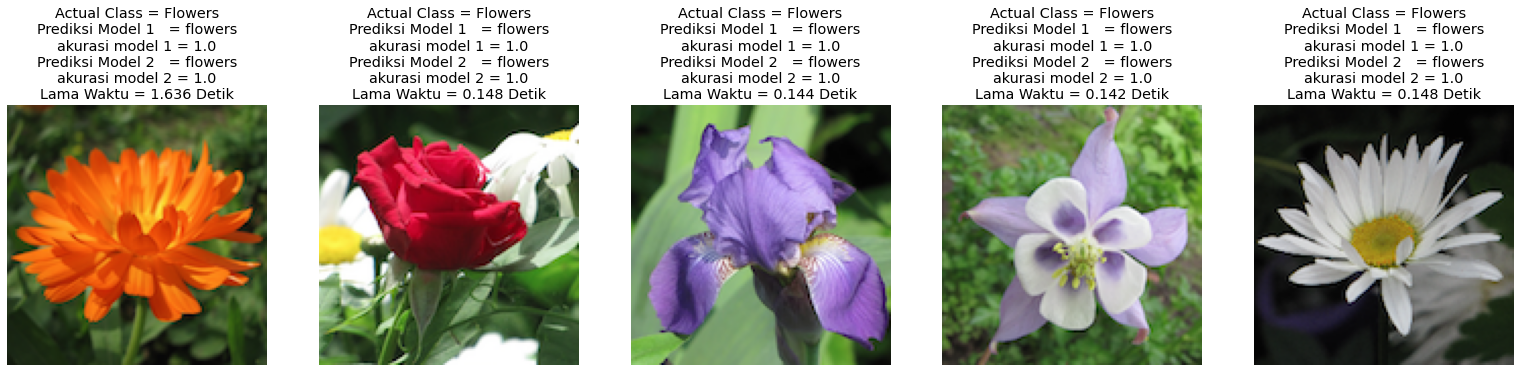

In [76]:
xz = 0

ncolu = 3
nrow = 5
fig = plt.gcf()
fig.set_size_inches(ncolu*9,nrow*4)
for i,fname in enumerate(fname1):
    sp = plt.subplot(3,5,i+1)
    sp.axis('off')
    img = mping.imread(fname)
    judul = 'Actual Class = Flowers' + '\nPrediksi Model 1   = ' + prediksi1[xz] + '\nakurasi model 1 = '+ str(akurasi1[xz]) +'\nPrediksi Model 2   = ' + prediksi2[xz] + '\nakurasi model 2 = '+ str(akurasi2[xz]) +'\nLama Waktu = ' + '{:.3f}'.format(waktu[xz]) + ' Detik'
    xz = xz+1
    plt.title(judul)
    plt.imshow(img)
plt.show()